# Image Registration Incorporating MirorrNet and DeepAtlas Tutorial
CSIRO Vacation Studentship Preliminary Work

Hannah Tay Nov 2022

### Imports

In [1]:
import monai
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import sys

# sys.path.append('src/image_registration/mirorrnet/src')
from mirorrnet.datasets.abideii import ABIDEIIPairedLDataModule

from utils import (
    preview_image, preview_3D_vector_field, preview_3D_deformation,
    jacobian_determinant, plot_against_epoch_numbers
)

# monai.config.print_config()

# Set deterministic training for reproducibility
# monai.utils.set_determinism(seed=2938649572)

/home/tay400/envs/mirorrnet/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### ABIDE-II Paired L Data Module

In [2]:
data_module = ABIDEIIPairedLDataModule(
    csv_file="/../../datasets/work/hb-atlas/work/scratch/data/ABIDEII/registered/participants.csv",
    n_valid=50
)

(676, 352)
(417, 352)
(417, 352)


In [3]:
data_module.setup()

In [4]:
dataloader_train = data_module.train_dataloader()
dataloader_valid = data_module.val_dataloader()

In [5]:
# resize and device options
resize = 96
device = torch.device("cuda:0")
num_segmentation_classes = 4

In [6]:
dice_loss = monai.losses.DiceLoss(
    include_background=True,
    to_onehot_y=True,  # Our seg labels are single channel images indicating class index, rather than one-hot
    softmax=True,  # Note that our segmentation network is missing the softmax at the end
    reduction="mean"
)

# A version of the dice loss with to_onehot_y=False and softmax=False;
# This will be handy for anatomy loss, for which we often compare two outputs of seg_net
dice_loss2 = monai.losses.DiceLoss(
    include_background=True,
    to_onehot_y=False,
    softmax=False,
    reduction="mean"
)

<h3>Registration Network</h3>

In [7]:
# Similar architecture to the one used in the paper
reg_net = monai.networks.nets.UNet(
    3,  # spatial dims
    1,  # input channels (one for fixed image and one for moving image)
    3,  # output channels (to represent 3D displacement vector field)
    (16, 32, 32, 32, 32),  # channel sequence
    (1, 2, 2, 2),  # convolutional strides
    dropout=0.2,
    norm="batch"
)

In [8]:
# segmentation network for use in anatomy loss
seg_net = monai.networks.nets.UNet(
    3,  # spatial dims
    1,  # input channels
    num_segmentation_classes,  # output channels
    (8, 16, 16, 32, 32, 64, 64),  # channel sequence
    (1, 2, 1, 2, 1, 2),  # convolutional strides
    dropout=0.2,
    norm='batch'
)

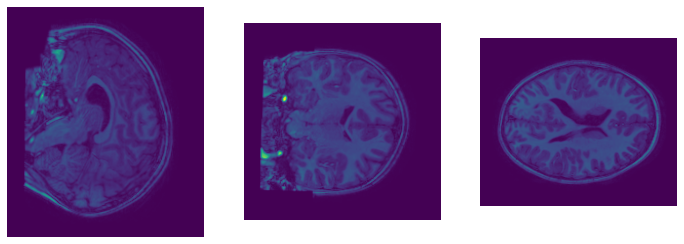

Shape of reg_net input: torch.Size([1, 1, 192, 224, 192])
Shape of reg_net output: torch.Size([1, 3, 192, 224, 192])


In [20]:
# Try out a forward pass
data_item = next(iter(dataloader_train))
# print(data_item)

reg_net_example_input = data_item['image_1']
preview_image(reg_net_example_input[0][0])

reg_net_example_output = reg_net(reg_net_example_input)
print(f"Shape of reg_net input: {reg_net_example_input.shape}")
print(f"Shape of reg_net output: {reg_net_example_output.shape}")
image_scale = reg_net_example_input.shape[-1]  # comes in handy later

# the output of reg-net will be interpreted as a displacement vector field

<h5>Image Warping</h5>

monai.networks.blocks.Warp: Using PyTorch native grid_sample.
torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)


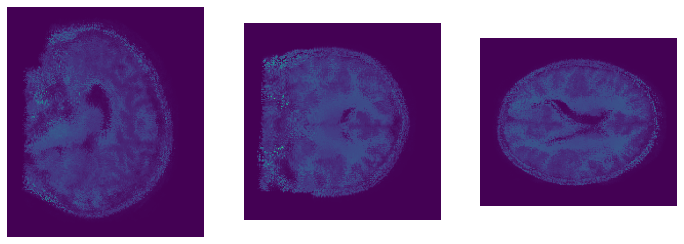

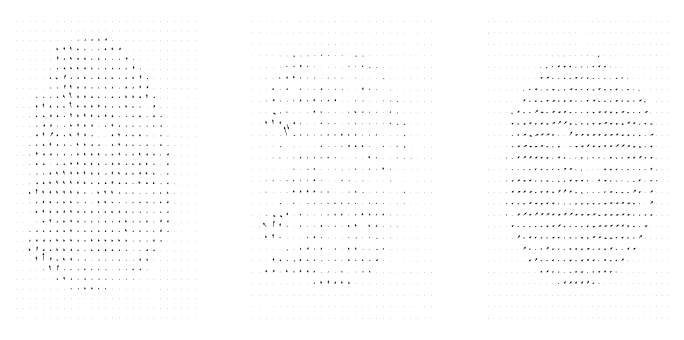

In [21]:
# For warping segmentation labels or class predictions, we sometimes want to use nearest neighbor interpolation
# Note that "bilinear" means "trilinear" in the case of 3D images
warp = monai.networks.blocks.Warp(mode="bilinear", padding_mode="border")
warp_nearest = monai.networks.blocks.Warp(mode="nearest", padding_mode="border")

# Use example reg_net output to apply warp
example_warped_image = warp(
    data_item['image_1'],  # moving image
    reg_net_example_output  # warping
)

# preview warped image from forward pass example above
preview_image(example_warped_image[0,0].detach())

# preview displacement field from forward pass example above
preview_3D_vector_field(reg_net_example_output.detach()[0])

<h5>Image Similarity Loss</h5>

In [22]:
# using normalised cross-correlation loss, measures the similarity between target and moving images
lncc_loss = monai.losses.LocalNormalizedCrossCorrelationLoss(
    spatial_dims=3,
    kernel_size=3,
    kernel_type='rectangular',
    reduction="mean"
)

# try out the image similarity loss on the example.
lncc_loss(
    example_warped_image, # registered image
    data_item['image_1'] # target ("fixed image")
)

tensor(-0.5976, grad_fn=<NegBackward0>)

<h5>Regularisation Loss</h5>

In [23]:
# produces smooth deformations
# makes the image registration elastic
bending_loss = monai.losses.BendingEnergyLoss()

# try out the bending energy loss on the example
bending_loss(reg_net_example_output)

tensor(3.2649, grad_fn=<MeanBackward0>)

### Training of Network

In [24]:
regularization_loss = bending_loss

def similarity_loss(displacement_field, image_pair):
    """ Accepts a batch of displacement fields, shape (B,3,H,W,D),
        and a batch of image pairs, shape (B,2,H,W,D). """
    warped_img2 = warp(image_pair[:, [1], :, :, :], displacement_field)
    return lncc_loss(
        warped_img2,  # prediction
        image_pair[:, [0], :, :, :]  # target
    )

In [25]:
def anatomy_loss(displacement_field, image_pair, seg_net, gt_seg1=None, gt_seg2=None):
    """
    Accepts a batch of displacement fields, shape (B,3,H,W,D),
    and a batch of image pairs, shape (B,2,H,W,D).
    seg_net is the model used to segment an image,
      mapping (B,1,H,W,D) to (B,C,H,W,D) where C is the number of segmentation classes.
    gt_seg1 and gt_seg2 are ground truth segmentations for the images in image_pair, if ground truth is available;
      if unavailable then they can be None.
      gt_seg1 and gt_seg2 are expected to be in the form of class labels, with shape (B,1,H,W,D).
    """
    if gt_seg1 is not None:
        # ground truth seg of target image
        seg1 = monai.networks.one_hot(
            gt_seg1, num_segmentation_classes
        )
    else:
        # seg_net on target image, "noisy ground truth"
        seg1 = seg_net(image_pair[:, [0], :, :, :]).softmax(dim=1)

    if gt_seg2 is not None:
        # ground truth seg of moving image
        seg2 = monai.networks.one_hot(
            gt_seg2, num_segmentation_classes
        )
    else:
        # seg_net on moving image, "noisy ground truth"
        seg2 = seg_net(image_pair[:, [1], :, :, :]).softmax(dim=1)

    # seg1 and seg2 are now in the form of class probabilities at each voxel
    # The trilinear interpolation of the function `warp` is then safe to use;
    # it will preserve the probabilistic interpretation of seg2.

    return dice_loss2(
        warp(seg2, displacement_field),  # warp of moving image segmentation
        seg1  # target image segmentation
    )

In [26]:
# Function for forward pass of reg_net, to avoid duplicating code between training and validation

def reg_losses(batch):
    img12 = batch['image_1'].to(device)

    displacement_field12 = reg_net(img12)

    loss_sim = similarity_loss(displacement_field12, img12)
    loss_reg = regularization_loss(displacement_field12)
    loss_ana = anatomy_loss(displacement_field12, img12, seg_net, gt_seg1=None, gt_seg2=None)

    return loss_sim, loss_reg, loss_ana

In [27]:
def create_batch_generator(dataloader_subdivided):
    """
    Create a batch generator that samples data pairs.

    Arguments:
        dataloader_subdivided : a mapping from the labels in seg_availabilities to dataloaders
        weights : a list of probabilities, one for each label in seg_availabilities;
                  if not provided then we weight by the number of data items of each type,
                  effectively sampling uniformly over the union of the datasets

    Returns: batch_generator
        A function that accepts a number of batches to sample and that returns a generator.
        The generator will weighted-randomly pick one of the seg_availabilities and
        yield the next batch from the corresponding dataloader.
    """

    def batch_generator(num_batches_to_sample):
        for _ in range(num_batches_to_sample):
            yield next(iter(dataloader_subdivided))
    return batch_generator

In [28]:
batch_generator_train_reg = create_batch_generator(dataloader_train)
batch_generator_valid_reg = create_batch_generator(dataloader_valid)

In [57]:
# Training cell - reg_net only - MOVED TO PY FILE train_reg_abideii.py

# reg_net.to(device)

# learning_rate_reg = 5e-4
# optimizer_reg = torch.optim.Adam(reg_net.parameters(), learning_rate_reg)

# lambda_a = 2.0  # anatomy loss weight
# lambda_sp = 3.0  # supervised segmentation loss weight

# # regularization loss weight
# # This often requires some careful tuning. Here we suggest a value, which unfortunately needs to
# # depend on image scale. This is because the bending energy loss is not scale-invariant.
# # 7.5 worked well with the above hyperparameters for images of size 128x128x128.
# lambda_r = 7.5 * (image_scale / 128)**2

# max_epochs = 120
# reg_phase_training_batches_per_epoch = 40
# reg_phase_num_validation_batches_to_use = 40
# val_interval = 5

# training_losses_reg = []
# validation_losses_reg = []

# best_reg_validation_loss = float('inf')

# for epoch_number in range(max_epochs):

#     print(f"Epoch {epoch_number+1}/{max_epochs}:")

#     losses = []
#     for batch in batch_generator_train_reg(reg_phase_training_batches_per_epoch):
#         optimizer_reg.zero_grad()
#         loss_sim, loss_reg, loss_ana = reg_losses(batch)
#         loss = loss_sim + lambda_r * loss_reg + lambda_a * loss_ana
#         loss.backward()
#         optimizer_reg.step()
#         losses.append(loss.item())

#     training_loss = np.mean(losses)
#     print(f"\treg training loss: {training_loss}")
#     training_losses_reg.append([epoch_number, training_loss])

#     if epoch_number % val_interval == 0:
#         reg_net.eval()
#         losses = []
#         with torch.no_grad():
#             for batch in batch_generator_valid_reg(reg_phase_num_validation_batches_to_use):
#                 loss_sim, loss_reg, loss_ana = reg_losses(batch)
#                 loss = loss_sim + lambda_r * loss_reg + lambda_a * loss_ana
#                 losses.append(loss.item())

#         validation_loss = np.mean(losses)
#         print(f"\treg validation loss: {validation_loss}")
#         validation_losses_reg.append([epoch_number, validation_loss])

#         if validation_loss < best_reg_validation_loss:
#             best_reg_validation_loss = validation_loss
#             torch.save(reg_net.state_dict(), 'reg_net_best.pth')

#     # Free up memory
#     del loss, loss_sim, loss_reg, loss_ana
#     torch.cuda.empty_cache()

# print(f"\n\nBest reg_net validation loss: {best_reg_validation_loss}")

In [58]:
# Plot the training and validation losses - MOVED TO PY FILE

# plot_against_epoch_numbers(training_losses_reg, label="training")
# plot_against_epoch_numbers(validation_losses_reg, label="validation")
# plt.legend()
# plt.ylabel('loss')
# plt.title('Alternating training: registration loss')
# plt.savefig('reg_net_losses.png')
# plt.show()

In [ ]:
# CHECKPOINT CELL; SAVE
# torch.save(reg_net.state_dict(), 'reg_net.pth')

# CHECKPOINT CELL; LOAD
reg_net.load_state_dict(torch.load('reg_net.pth'))

### Visualisation of Results

In [ ]:
# try out reg net on a random validation pair

reg_net.to(device)
reg_net.eval()

data_item = next(iter(dataloader_valid))
img12 = data_item['image_1'].to(device)

with torch.no_grad():
    reg_net_example_output = reg_net(img12)

example_warped_image = warp(
    img12[:, [1], :, :, :],  # moving image
    reg_net_example_output  # warping
)

# Uncomment to preview displacement field and warped image
print("moving image:")
preview_image(img12[0, 1, :, :, :].cpu(), normalize_by="slice", cmap='gray')
print("target image:")
preview_image(img12[0, 0, :, :, :].cpu(), normalize_by="slice", cmap='gray')
print("warped moving image:")
preview_image(example_warped_image[0, 0].cpu(), normalize_by="slice", cmap='gray')
print("deformation vector field, projected into viewing planes:")
preview_3D_vector_field(reg_net_example_output.cpu().detach()[0])
print("deformation applied to a grid, projected into viewing planes:")
preview_3D_deformation(reg_net_example_output.cpu().detach()[0], 5, linewidth=1, color='darkblue')
print("jacobian determinant:")
det = jacobian_determinant(reg_net_example_output.cpu().detach()[0])
preview_image(det, normalize_by='slice', threshold=0)
loss = lncc_loss(example_warped_image, img12[:, [0], :, :, :]).item()
print(f"Similarity loss: {loss}")
print(f"number of folds: {(det<=0).sum()}")

del reg_net_example_output, img12, example_warped_image
torch.cuda.empty_cache()

<h5>Count Folds</h5>
<p>
That last image, the Jacobian determinant field, is a useful way to visualize the effect of the deformation generated by reg_net. This is a scalar field that tells us, at each voxel, the scale factor by which volumes are scaled near that voxel. Where it's negative, it's telling us that the deformation map locally reverses orientation at that location. We refer to voxels where the Jacobian determinant is negative as "folds." Folds are shown in red in the preview above.
<br><br>
The number of folds that occur while registering a pair of images is a nice way to think about how "bad" the deformation is.
</p>

In [ ]:
# evaluate the regularity of reg_net by sampling some images from the validation set and counting folds
# increasing lambda_r can improve results

num_batches_for_histogram = 200  # sample this many batches

fold_counts = []  # Each element is the number of folds that occur in the registration of some image pair
negative_det_values = []  # Each element is the jacobian determinant at some fold for some image pair
reg_net.eval()
with torch.no_grad():
    for batch in batch_generator_valid_reg(num_batches_for_histogram):
        img12 = batch['img12'].to(device)
        displacement_fields = reg_net(img12)
        for displacement_field in displacement_fields:
            det = jacobian_determinant(displacement_field).cpu()
            num_folds = (det <= 0).sum()
            fold_counts.append(num_folds)
            if len(negative_det_values) < 1e6:  # Limit how many of these values we store
                negative_det_values += det[det <= 0].tolist()

del img12, displacement_fields
torch.cuda.empty_cache()

plt.hist(fold_counts)
plt.title("Number of folds")
plt.savefig('histogram_num_folds.png')
plt.show()
print(f"Mean fold count: {np.mean(fold_counts)} folds, out of {det.size} locations.")

In [ ]:
plt.hist(negative_det_values)

# View counts logarithmically to see details for the worse jacobians, where counts are usually smaller
plt.yscale('log')

plt.title("Negative Jacobian values")
plt.savefig('histogram_neg_jac.png')
plt.show()